<h2>Генерация выборок данных</h2>

In [107]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [4]:
x = np.linspace(-10, 10, 300, dtype = np.float32).reshape((-1, 1))
y = np.sin(3 * x)

transformer = RobustScaler().fit(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_Validation, y_train, y_Validation = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

print(f"train size: {X_train.shape[0]}")
print(f"validation size: {X_Validation.shape[0]}")
print(f"test size: {X_test.shape[0]}")

train size: 180
validation size: 90
test size: 30


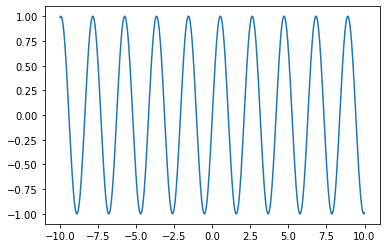

In [5]:
data = np.linspace(-10, 10, 2000)

plt.plot(data, np.sin(3 * data))

{'whiskers': [<matplotlib.lines.Line2D at 0x1d08f56f820>,
 'caps': [<matplotlib.lines.Line2D at 0x1d08f56fee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d08f56f520>],
 'medians': [<matplotlib.lines.Line2D at 0x1d08f57e5e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d08f57e940>],
 'means': []}

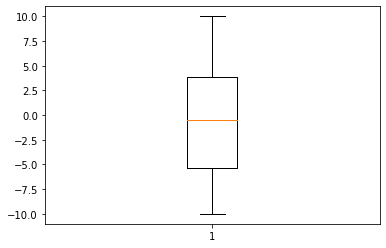

In [6]:
plt.boxplot(X_train)

In [7]:
#%pip install torch

<h2>Архитекутра и обучение НС</h2>

In [8]:
import torch.nn as nn
import torch
from torch.autograd import Variable

In [9]:
class SinNet(nn.Module):
    
    def __init__(self, n_hidden_neurons):
        super(SinNet, self).__init__()

        self.fc1 = nn.Linear(1, n_hidden_neurons)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(n_hidden_neurons, 1)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.act2 = nn.functional.tanh

    def forward(self, x):
        x = self.fc1(x)
        x = self.act2(x)
        x = self.fc2(x)
        return x
    
    def forward_hidden(self, x):
        x = self.fc1(x)
        x = self.act2(x)
        return x

In [96]:
def fit_net(net, x, y, x_valid, y_valid, x_test, y_test, epoch = 100, lr = 0.01):
    x_valid = Variable(torch.from_numpy(x_valid))
    y_valid = Variable(torch.from_numpy(y_valid))
    x_test = Variable(torch.from_numpy(x_test))
    y_test = Variable(torch.from_numpy(y_test))
    x = Variable(torch.from_numpy(x), requires_grad=True)
    y = Variable(torch.from_numpy(y), requires_grad=True)

    step_losses = []
    valid_losses = []
    train_losses = []
    test_losses = []

    weights_hidden = []
    weights_output = []
    bias_hedden = []

    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)

    for _ in range(epoch):

        param = list(net.parameters())[0:3]
        weights_hidden.append(param[0].detach().numpy().reshape(1, -1)[0])
        weights_output.append(param[1].detach().numpy())
        bias_hedden.append(param[2].detach().numpy())

        y_pred_valid = net.forward(x_valid)
        L_valid = loss(y_pred_valid, y_valid)
        valid_losses.append(L_valid.item())

        if ((len(step_losses) > 0) and (step_losses[-1] < L_valid.item())):
            step_losses.append(L_valid.item())
        else:
            step_losses = [L_valid.item()]

        y_pred_test = net.forward(x_test)
        L_test = loss(y_pred_test, y_test)
        test_losses.append(L_test.item())

        optimizer.zero_grad() 
        y_pred = net.forward(x)
        L = loss(y_pred, y)
        train_losses.append(L.item())

        if len(step_losses) >= 500:
            break

        L.backward()
        optimizer.step()

    return train_losses, valid_losses, test_losses, weights_hidden, weights_output, bias_hedden

<h2>Визуализация параметров модели</h2>

In [11]:
def visualize_output(net, x, x_input, title):
    x_input_tensor = Variable(torch.from_numpy(x_input))
    y = net.forward(x_input_tensor).data.numpy()

    plt.figure(figsize=(12, 8))
    plt.scatter(x, y, c = 'r')
    plt.scatter(x, np.sin(3 * x), c = 'b')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    x = x[x[:, 0].argsort()]
    x_input = x_input[x_input[:, 0].argsort()]
    x_input_tensor = Variable(torch.from_numpy(x_input))
    outputs = net.forward_hidden(x_input_tensor).data.numpy().T
    
    plt.figure(figsize=(12, 8))
    for output in outputs:
        plt.plot(x, output)

    plt.xlabel("x")
    plt.ylabel("$y_k$")
    plt.title(title)
    plt.show()

In [12]:
def visualize_y(net, x, x_input, title, y = None):
    
    if y is None:
        x_input_tensor = Variable(torch.from_numpy(x_input))
        y = net.forward(x_input_tensor).data.numpy()
    
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.scatter(x, y)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [93]:
def visualize_losses(losses):
    
    t = np.arange(1, len(losses[0]) + 1)
    plt.figure(figsize=(12, 8))
    plt.plot(t, losses[0], label = "loss training")
    plt.plot(t, losses[1], label = "loss valid")
    plt.plot(t, losses[2], label = "loss test")

    plt.legend(fontsize = 20)
    plt.xlabel("t")
    plt.ylabel("$E(t)$")
    plt.show()

In [72]:
def visualize_weights(weights, title):
    
    t = np.arange(1, len(weights) + 1)
    weights = list(zip(*weights))

    plt.figure(figsize=(12, 8))
    for W in weights:
        plt.plot(t, W)
        #plt.fill_between(t, W, np.zeros_like(W[-100:]), color = "orange", alpha = 0.2)
        
    plt.title(title)
    plt.xlabel("t")
    plt.ylabel("$w(t)$")
    plt.show()

<h2>Тестирование нейронной сети</h2>

In [101]:
X_train_input = transformer.transform(X_train)
X_Validation_input = transformer.transform(X_Validation)
X_test_input = transformer.transform(X_test)

net = SinNet(20)
print(net)

SinNet(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


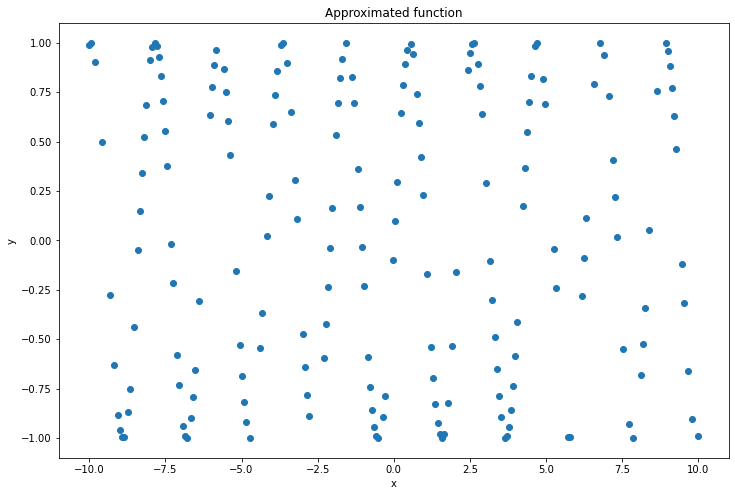

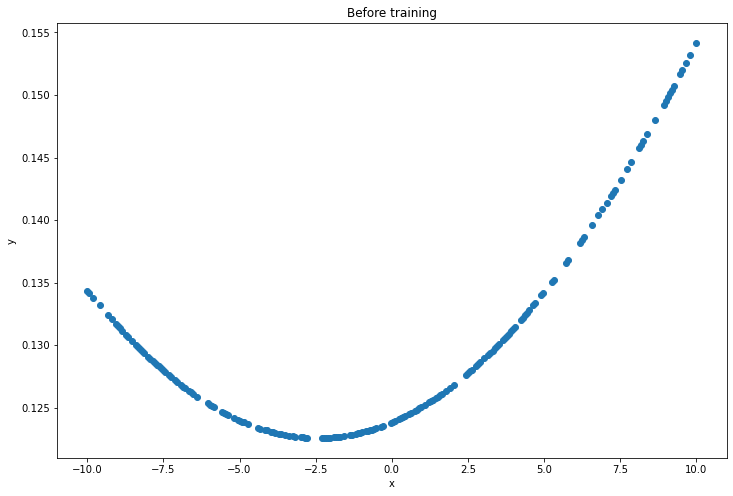

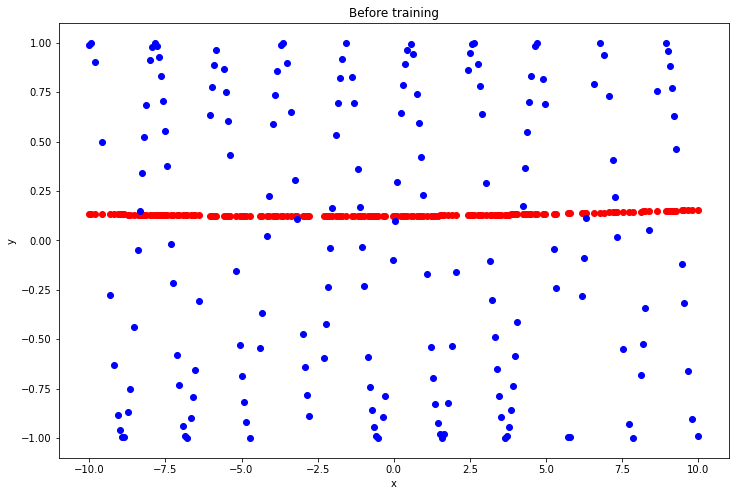

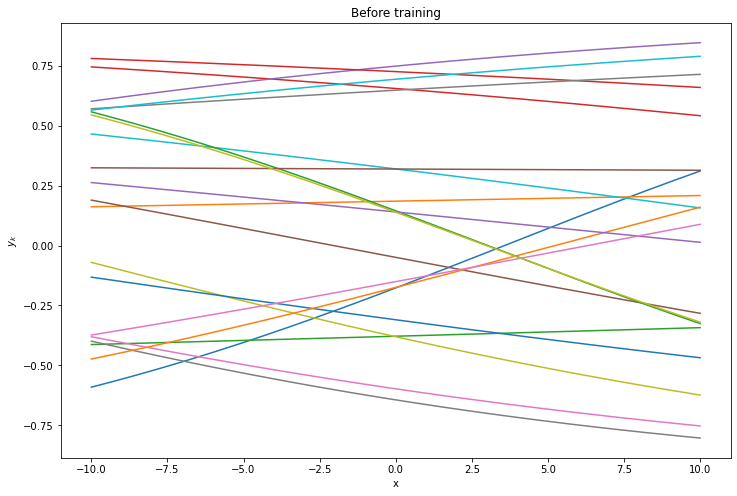

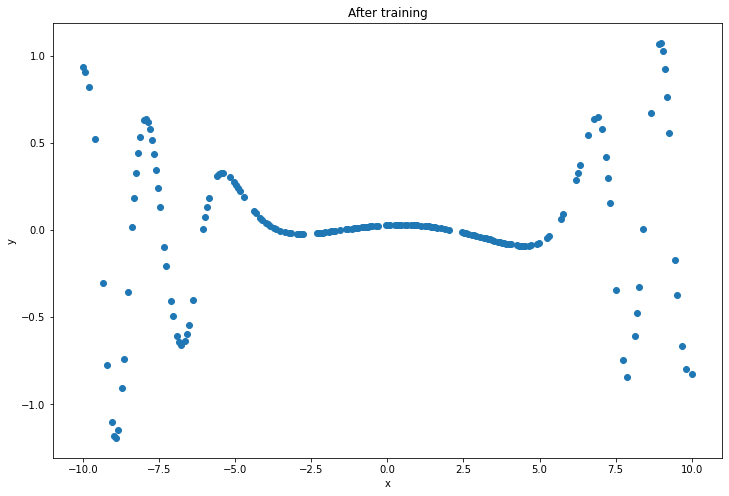

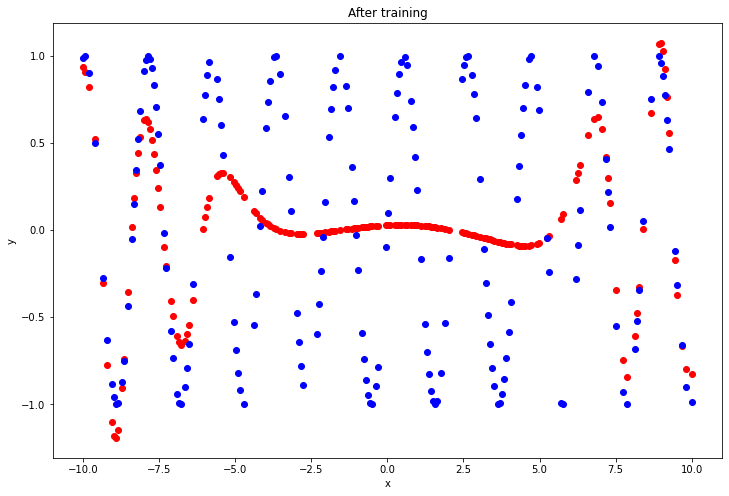

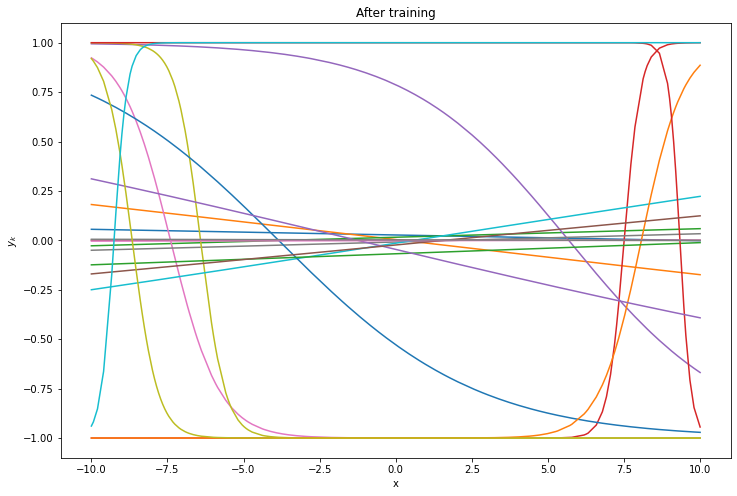

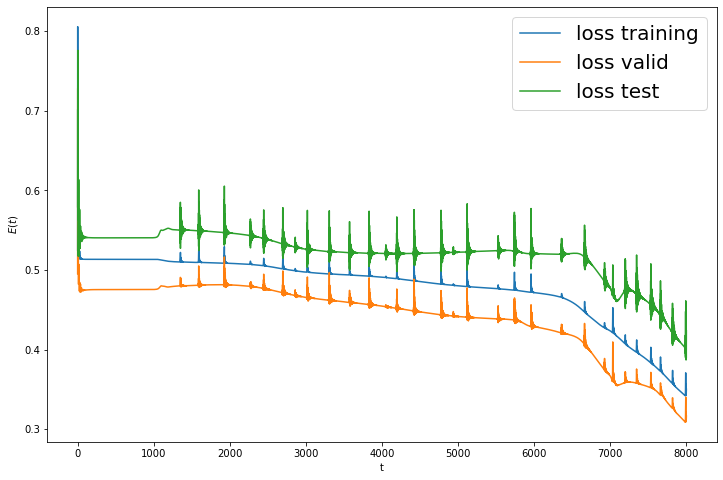

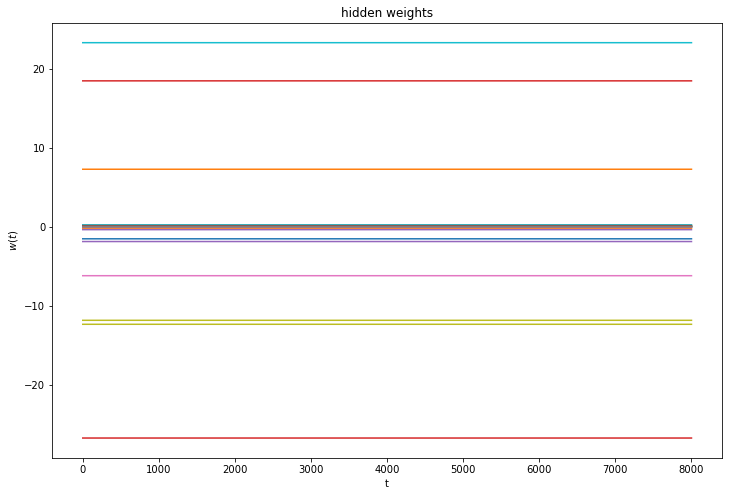

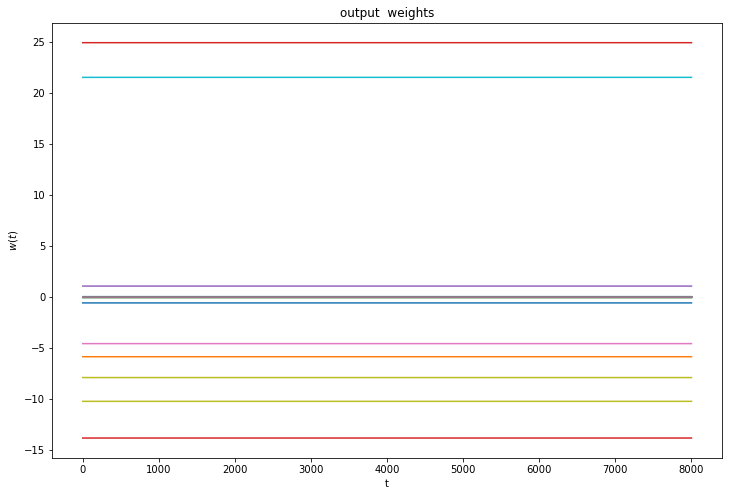

In [102]:
visualize_y(net, X_train, X_train_input, "Approximated function", np.sin(3 * X_train))

visualize_y(net, X_train, X_train_input, "Before training")
visualize_output(net, X_train, X_train_input, "Before training")

result = fit_net(net, X_train_input, y_train, X_Validation_input, y_Validation, X_test_input, y_test, epoch = 8000, lr = 0.05)

visualize_y(net, X_train, X_train_input, "After training")
visualize_output(net, X_train, X_train_input, "After training")

visualize_losses(result[0:3])

visualize_weights(result[3], "hidden weights")
visualize_weights(result[4], "output  weights")
#visualize_weights(result[5], "bias")

In [103]:
def get_losses(net, X_train, y_train, X_valid, y_valid, X_test, y_test):
    x_train = Variable(torch.from_numpy(X_train))
    y_train = Variable(torch.from_numpy(y_train))
    x_valid = Variable(torch.from_numpy(X_valid))
    y_valid = Variable(torch.from_numpy(y_valid))
    x_test = Variable(torch.from_numpy(X_test))
    y_test = Variable(torch.from_numpy(y_test))

    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()

    mae_value = []
    mse_value = []
    rmse_value = []
    for x, y in zip([x_train, x_valid, x_test], [y_train, y_valid, y_test]):
        mae_value.append(round(mae_loss(net.forward(x), y).item(), 3))
        mse_value.append(round(mse_loss(net.forward(x), y).item(), 3))
    
    rmse_value = [round(value**0.5, 3) for value in mse_value]

    data = {"MAE": mae_value,
            "MSE": mse_value,
            "RMSE": rmse_value}
    index = ["train", "valid", "test"]

    df = pd.DataFrame(data = data, index = index)
    return df

In [104]:
#ошибки после основного обучения
print(get_losses(net, X_train_input, y_train, X_Validation_input, y_Validation, X_test_input, y_test))

         MAE    MSE   RMSE
train  0.472  0.343  0.586
valid  0.434  0.311  0.558
test   0.488  0.399  0.632


<h2>Улучшение качества аппроксимации</h2>

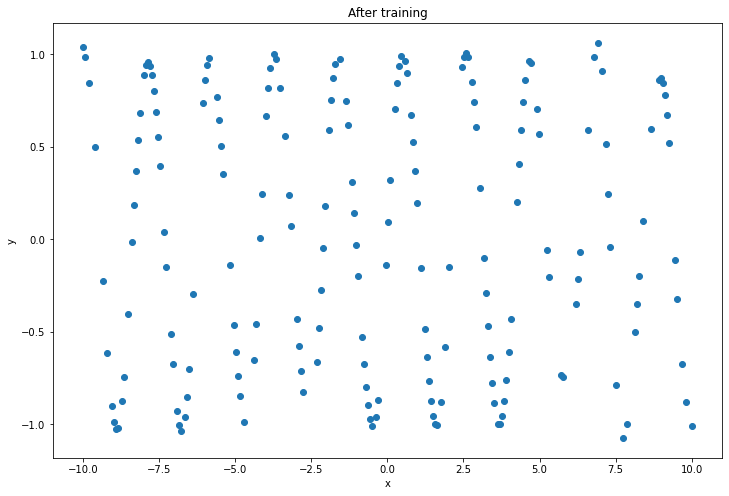

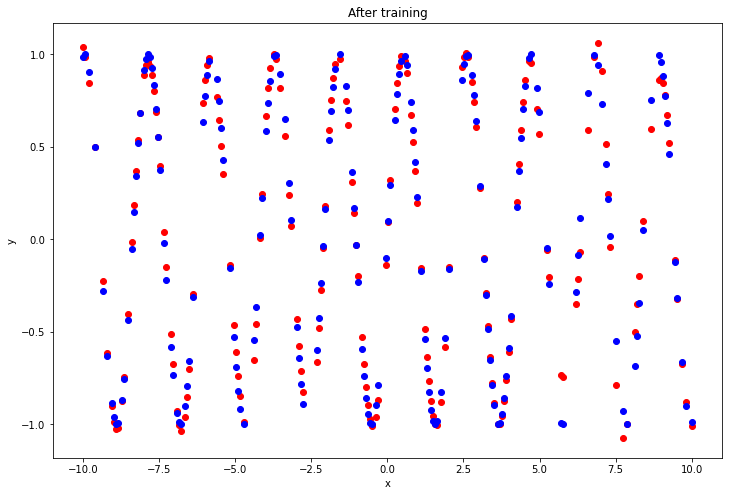

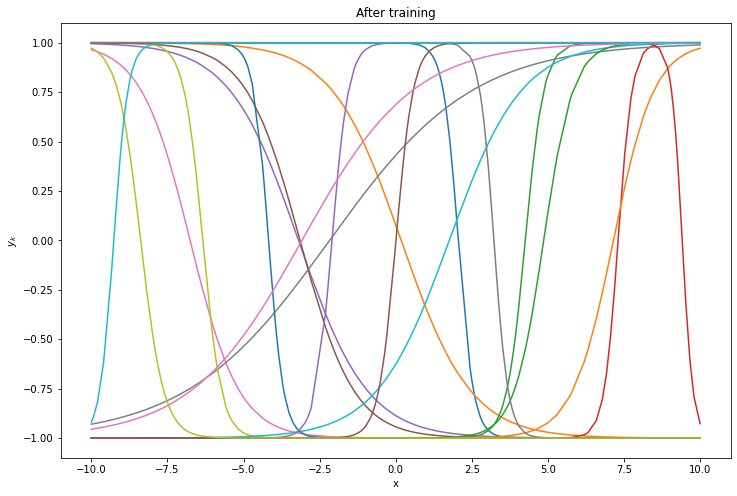

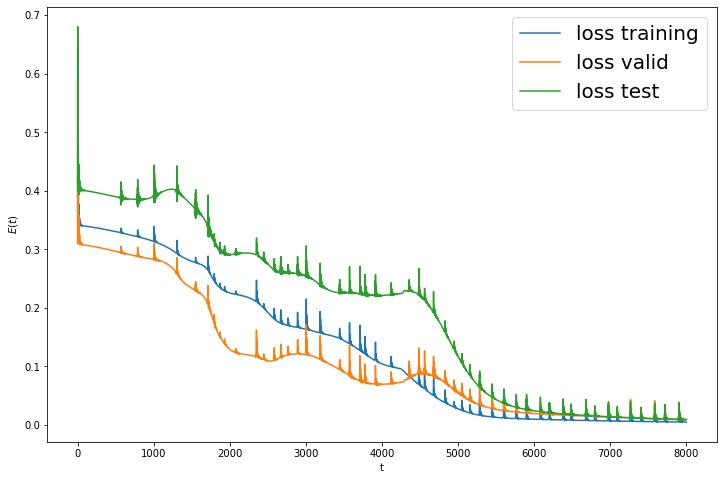

In [105]:
result = fit_net(net, X_train_input, y_train, X_Validation_input, y_Validation, X_test_input, y_test, epoch = 8000, lr = 0.05)

visualize_y(net, X_train, X_train_input, "After training")
visualize_output(net, X_train, X_train_input, "After training")

visualize_losses(result[0:3])

In [106]:
print(get_losses(net, X_train_input, y_train, X_Validation_input, y_Validation, X_test_input, y_test))

         MAE    MSE   RMSE
train  0.052  0.005  0.071
valid  0.077  0.010  0.100
test   0.069  0.009  0.095
